In [1]:
%load_ext autoreload
%autoreload 2

# Exercise 9

<img src="./images/09.png" width=800>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from tqdm.autonotebook import tqdm
from collections import defaultdict
import os
import numpy as np
import pandas as pd
import mlflow
from torchinfo import summary
import time
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from utils import set_seed, weight_reset
from typing import DefaultDict, Any, Callable, Optional


/tmp/ipykernel_8124/2062756509.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [ ]:
os.environ['MLFLOW_TRACKING_URI'] = './mlruns08_9'
mlflow.set_tracking_uri(os.environ.get('MLFLOW_TRACKING_URI'))

In [ ]:
mlflow.set_experiment('Exercise08_9')

<Experiment: artifact_location='/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_07/mlruns07_1/143507330168611334', creation_time=1750415411076, experiment_id='143507330168611334', last_update_time=1750415411076, lifecycle_stage='active', name='Exercise07_1', tags={}>

In [3]:
torch.backends.cudnn.deterministic = True
set_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Dataset and DataLoader

In [4]:
from torchvision.tv_tensors import BoundingBoxes, BoundingBoxFormat

class CatDogDataset(torch.utils.data.Dataset):
    """
    A custom Dataset class for loading cat and dog images with XML annotations.
    """
    def __init__(self, image_dir, annot_dir, transforms=None):
        """
        Args:
            image_dir (str): Path to the directory with images.
            annot_dir (str): Path to the directory with XML annotations.
            transforms (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.transforms = transforms

        # Get a sorted list of annotation file names to ensure consistency
        self.annot_files = sorted([f for f in os.listdir(annot_dir) if f.endswith('.xml')])

        # Define the class-to-index mapping.
        # IMPORTANT: 0 is reserved for the background class.
        self.class_to_idx = {'cat': 1, 'dog': 2}

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.annot_files)

    def __getitem__(self, idx):
        """
        Fetches the sample at the given index.

        Args:
            idx (int): The index of the sample.

        Returns:
            tuple: (image, target) where target is a dictionary containing
                bounding boxes and labels.
        """
        # 1. Get the annotation file path and parse it
        annot_path = os.path.join(self.annot_dir, self.annot_files[idx])
        tree = ET.parse(annot_path)
        root = tree.getroot()

        # 2. Get the corresponding image file path and load the image
        img_filename = root.find('filename').text
        img_path = os.path.join(self.image_dir, img_filename)
        # Use PIL to open the image, converting to RGB
        image = Image.open(img_path).convert("RGB")
        width, height = image.size
        # 3. Extract bounding boxes and labels from the XML
        boxes_coords = []
        labels_list = []
        for obj in root.findall('object'):
            # Get class label and convert to integer index
            label_name = obj.find('name').text
            if label_name in self.class_to_idx:
                labels_list.append(self.class_to_idx[label_name])
            else:
                continue # Skip if the class is not 'cat' or 'dog'

            # Get bounding box coordinates
            bbox = obj.find('bndbox')
            
            # --- FIX: Use float() instead of int() to handle decimal values ---
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes_coords.append([xmin, ymin, xmax, ymax])
        # print(boxes_coords)
        # 4. Convert lists to PyTorch tensors
        # This part correctly handles the conversion to the required float32 tensor
        if not boxes_coords:
            # If no objects, create empty tensors with the correct shape
            boxes = BoundingBoxes(torch.empty((0, 4)), format="XYXY", canvas_size=(height, width))
            labels = torch.empty(0, dtype=torch.int64)
        else:
            # Otherwise, convert the lists to BoundingBoxes and a tensor
            boxes = BoundingBoxes(boxes_coords, format="XYXY", canvas_size=(height, width))
            labels = torch.as_tensor(labels_list, dtype=torch.int64)

        # 5. Assemble the target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # You can add other info if needed, e.g., image_id
        target["image_id"] = torch.tensor([idx])

        # 6. Apply transformations (if any)
        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target


In [5]:
from torchvision.transforms import v2 as T

def get_transforms(train):
    """
    Returns a composition of transforms for image and bounding boxes.
    
    Args:
        train (bool): If True, applies training data augmentations.
    """
    transforms = []
    
    # 1. Convert PIL image to a TVTensor
    # The v2 transforms expect a TVTensor, which is a subclass of torch.Tensor
    transforms.append(T.ToImage())

    # 2. Apply data augmentation if in training mode
    if train:
        # Randomly flip the image horizontally with a 50% probability
        # The bounding boxes are automatically flipped as well
        transforms.append(T.RandomHorizontalFlip(p=0.5))

    # 3. Resize the image and bounding boxes
    # Note: This might stretch the image if the aspect ratio is different.
    # You could also use something like T.ResizeShortestEdge with T.Pad
    # for more advanced resizing that preserves the aspect ratio.
    transforms.append(T.Resize((128, 128), antialias=True))
    
    # 4. Convert image pixel values from [0, 255] to [0.0, 1.0] and ensure it's a float tensor
    transforms.append(T.ToDtype(torch.float32, scale=True))

    return T.Compose(transforms)

In [6]:
image_dir = './images08_9'
annot_dir = './Annotations08_9'
transforms = get_transforms(False)
catdog_dataset = CatDogDataset(image_dir, annot_dir, transforms=transforms)

In [7]:
catdog_dataset[40][1]

{'boxes': BoundingBoxes([], size=(0, 4), format=BoundingBoxFormat.XYXY, canvas_size=(128, 128)),
 'labels': tensor([], dtype=torch.int64),
 'image_id': tensor([40])}

In [8]:
catdog_dataset[20][1]

{'boxes': BoundingBoxes([[ 44.1856,   8.5753, 124.7558, 126.3283],
                [ 11.9017,  48.4721,  51.3769, 127.4334]], format=BoundingBoxFormat.XYXY, canvas_size=(128, 128)),
 'labels': tensor([2, 1]),
 'image_id': tensor([20])}

Processing image at index 20
Image size: (128, 128)


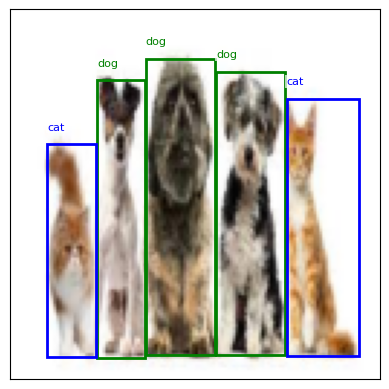

Processing image at index 40
Image size: (128, 128)


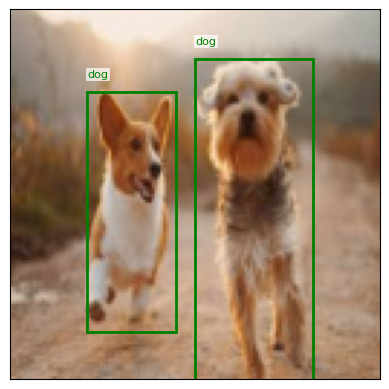

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch # Assuming your dataset returns PyTorch tensors
from torchvision.transforms.functional import to_pil_image # If your image is a tensor

# IMPORTANT: These imports and class definitions would need to be present
# in the same script or imported from a separate file if not already.
# Since the request is ONLY to modify the plotting part, I'm assuming
# CatDogDataset and get_transforms are defined elsewhere and accessible.
# For this code to run independently, you'd need the full definitions of
# CatDogDataset and get_transforms at the top.

# from torchvision.tv_tensors import BoundingBoxes, BoundingBoxFormat
# import os
# import xml.etree.ElementTree as ET
# from PIL import Image
# from torchvision.transforms import v2 as T

# (Assuming CatDogDataset and get_transforms are defined above or imported)

# --- Start of modifications for plotting ---

# Define a color map for different classes
# We recreate the idx_to_class mapping here as we cannot modify the Dataset class
# based on the assumption that cat=1 and dog=2.
CLASS_IDX_TO_NAME = {1: 'cat', 2: 'dog'}
COLORS = {
    'cat': 'blue',
    'dog': 'green',
    'unknown': 'red' # Default color for unknown classes or if an issue occurs
}

image_dir = './images08_9'
annot_dir = './Annotations08_9'

# Assuming CatDogDataset and get_transforms are already defined/imported
# If not, you'd need their full definitions here.
# For the purpose of this isolated modification, we assume they exist.
transforms = get_transforms(False)
catdog_dataset = CatDogDataset(image_dir, annot_dir, transforms=transforms)

# Example with bounding boxes (index 20)
image_data_with_boxes, target_with_boxes = catdog_dataset[15]

# Example with potentially no bounding boxes (index 40)
image_data_no_boxes, target_no_boxes = catdog_dataset[30]

# Let's demonstrate with both cases
for image_data, target, idx in [(image_data_with_boxes, target_with_boxes, 20), (image_data_no_boxes, target_no_boxes, 40)]:
    print(f"Processing image at index {idx}")

    # Convert the image tensor to a PIL Image or NumPy array if necessary
    if isinstance(image_data, torch.Tensor):
        image_pil = to_pil_image(image_data)
    else:
        image_pil = image_data

    print(f"Image size: {image_pil.size}")

    # Get bounding box coordinates and labels
    boxes = target['boxes'].cpu().numpy() # Convert to NumPy array and move to CPU if on GPU
    labels = target['labels'].cpu().numpy() # Get labels

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image_pil)

    # Add bounding boxes only if there are any
    if boxes.shape[0] > 0: # Check if the array of boxes is not empty
        for i, box in enumerate(boxes): # Use enumerate to get index for labels
            # Bounding box format: [x_min, y_min, x_max, y_max]
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min

            label_idx = labels[i]
            class_name = CLASS_IDX_TO_NAME.get(label_idx, 'unknown')
            box_color = COLORS.get(class_name, 'red') # Get color based on class name

            # Create a Rectangle patch
            rect = patches.Rectangle(
                (x_min, y_min),
                width,
                height,
                linewidth=2,
                edgecolor=box_color, # Use the class-specific color
                facecolor='none'
            )

            # Add the patch to the Axes
            ax.add_patch(rect)

            # Add text annotation for the object name
            ax.text(
                x_min, y_min - 5, # Position text slightly above the box
                class_name,
                color=box_color, # Text color matches box color
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
            )
    else:
        print("No bounding boxes to display for this image.")

    # Remove axis ticks and labels for cleaner display
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.show()

In [21]:
def collate_fn(batch):
    """
    batch is going to contain a python list of objects. In our case, our data loader returns (Tensor, Dict) pairs
    The FasterRCNN algorithm wants a List[Tensors] and a List[Dict]. So we will use this function to convert the 
    batch of data into the form we want, and then give it to the Dataloader to use
    """
    imgs = []
    labels = []
    for img, label in batch:
        imgs.append(img)
        labels.append(label)
    return imgs, labels

In [ ]:
train_data , test_data = random_split(catdog_dataset, [40, len(catdog_dataset)-40])
batch_size = 5
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

## Model

In [ ]:
C = 1
classes = 10
n_filters = 32

In [ ]:
def cnn_layer(in_filters, out_filters, kernel_size=3):
    """
    in_filters: how many channels are in the input to this layer
    out_filters: how many channels should this layer output
    kernel_size: how large should the filters of this layer be
    """
    padding = kernel_size//2
    return nn.Sequential(
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.BatchNorm2d(out_filters),
        nn.LeakyReLU(), # I'm not setting the leak value to anything just to make the code shorter. 
    )
backbone = nn.Sequential(
    cnn_layer(C, n_filters),    
    cnn_layer(n_filters, n_filters),
    cnn_layer(n_filters, n_filters),
    nn.MaxPool2d((2,2)),
    cnn_layer(n_filters, 2*n_filters),
    cnn_layer(2*n_filters, 2*n_filters),
    cnn_layer(2*n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    cnn_layer(2*n_filters, 4*n_filters),
    cnn_layer(4*n_filters, 4*n_filters),
)
#Let Faster RCNN know exactly how many output channels to expect
backbone.out_channels = n_filters*4

In [ ]:
# How many proposals $k$ should be generated? Every aspect ration will be one, and the process will be repeated for multiple image sizes 
anchor_generator = AnchorGenerator(sizes=((16, 32, 64, 128),), aspect_ratios=((0.5, 1.0, 2.0),)) #To make this run faster, we are telling PyTorch to look for only square images that are 32 x 32 in size

#Tell PyTorch to use the final output of the backbone as the featuremap (['0']), use adaptive pooling down to a 7x7 grid (output_size=7)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
#sampling_ratio is poorly named, and controls details on how the RoI grabs slices of the feature map when a fractional pixel location is predicted (e.g., 5.8 instead of 6). We are not going to go into those low level details, 2 is a reasonable default for most work. 
        
#Now we can create the FasterRCNN object. We give it the backbone network, number of classes, min & max size to process images at (we know all our images at 100 pixels), a mean and standard deviation to subtract from the images, and the anchor generation (RPN) and RoI objects
model = FasterRCNN(backbone,
                num_classes=3,
                image_mean=[0.485, 0.456, 0.406],
                image_std=[0.229, 0.224, 0.225],
                min_size=128,
                max_size=128,
                rpn_anchor_generator=anchor_generator,
                box_roi_pool=roi_pooler)

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

# Load a pre-trained model
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model2 = fasterrcnn_resnet50_fpn_v2(
    weights=weights,
    min_size=128,
    max_size=128,)

# Replace the classifier head for your number of classes
num_classes = 3 # 2 classes (cat, dog) + 1 background
in_features = model2.roi_heads.box_predictor.cls_score.in_features
model2.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

## Training

In [ ]:
from torchmetrics.detection import MeanAveragePrecision

In [ ]:
epochs = 50
params = {
    'device': device,
    'epochs': epochs,
    'batch_size': batch_size,
    }

In [ ]:
def train_network(optimizer, metric_calculator ,train_loader, test_loader=None):
    results = defaultdict(list)
    total_train_time = 0

    # --- Main Training and Validation Loop ---
    for epoch in tqdm(range(epochs), desc="Epoch"):
        results['epoch'].append(epoch)
        
        # ===================================
        #           TRAINING
        # ===================================
        model.train() # Set model to training mode
        running_train_loss = []
        start_time = time.time()
        
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs = [img.to(device) for img in inputs]
            labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

            # Get losses
            loss_dict = model(inputs, labels)
            loss = sum(l for l in loss_dict.values())
            
            # Backpropagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_train_loss.append(loss.item())

        # --- Log Training Results for Epoch ---
        total_train_time += (time.time() - start_time)
        avg_train_loss = np.mean(running_train_loss)
        results['train loss'].append(avg_train_loss)
        results['total time'].append(total_train_time)
        
        mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
        mlflow.log_metric('Time', total_train_time, step=epoch)

        # ===================================
        #           VALIDATION
        # ===================================
        if test_loader is not None:
            metric_calculator.reset() # Reset metrics before each validation run
            running_valid_loss = []
            
            with torch.no_grad(): # Disable gradient calculations
                for inputs, labels in tqdm(test_loader, desc="Validating", leave=False):
                    inputs = [img.to(device) for img in inputs]
                    labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
                    
                    # 1. Get validation loss (model in .train() mode)
                    model.train()
                    loss_dict = model(inputs, labels)
                    loss = sum(l for l in loss_dict.values())
                    running_valid_loss.append(loss.item())

                    # 2. Get predictions for metrics (model in .eval() mode)
                    model.eval()
                    predictions = model(inputs)
                    
                    # Update the metric calculator with the new predictions and labels
                    metric_calculator.update(predictions, labels)

            # --- Log Validation Results for Epoch ---
            avg_valid_loss = np.mean(running_valid_loss)
            results['valid loss'].append(avg_valid_loss)
            mlflow.log_metric("valid_loss", avg_valid_loss, step=epoch)

            # Compute and log the final mAP scores
            metrics = metric_calculator.compute()
            results['valid_mAP'].append(metrics['map'].item())
            mlflow.log_metric("valid_mAP", metrics['map'].item(), step=epoch)
            mlflow.log_metric("valid_mAP_50", metrics['map_50'].item(), step=epoch)
            mlflow.log_metric("valid_mAP_75", metrics['map_75'].item(), step=epoch)

        # print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f} | mAP: {metrics['map'].item():.4f}")

In [ ]:
model = model2
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
params['optimizer'] = optimizer.defaults

# --- Metric Calculator ---
# This object will accumulate predictions and targets to calculate mAP
metric_calculator = MeanAveragePrecision(box_format="xyxy")

with mlflow.start_run(run_name='cat_dog_detection'):
    with open('model_summary.txt', 'w') as f:
        f.write(str(summary(model, inpt_size=(batch_size,tuple(catdog_dataset[0][0].shape)))))
    mlflow.log_artifact('model_summary.txt')
    mlflow.log_params(params)
    train_network(
        optimizer=optimizer,
        metric_calculator=metric_calculator,
        train_loader=train_loader,
        test_loader=test_loader,
        )